In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import time

# Principle Components Analysis (PCA)

## サンプルデータの生成
- 3次元、長さ1000の時系列データ

In [2]:
# サンプルの時系列データを生成
np.random.seed(0)
size = 1000
time_series_data = pd.DataFrame({
    'time': pd.date_range(start='1/1/2020', periods=size, freq='D'),
    'feature1': np.random.randn(size).cumsum(),
    'feature2': np.random.randn(size).cumsum(),
    'feature3': np.random.randn(size).cumsum()
})

X = time_series_data[['feature1', 'feature2', 'feature3']].values
print(f"X: {X.shape}")

X: (1000, 3)


### 散布図行列
- 各要素がどの程度相関しているかを確認するために散布図行列を作成する
- 対角成分については、ヒストグラムになっている
- 今回のデータについては、x1とx3に正の相関がみられる

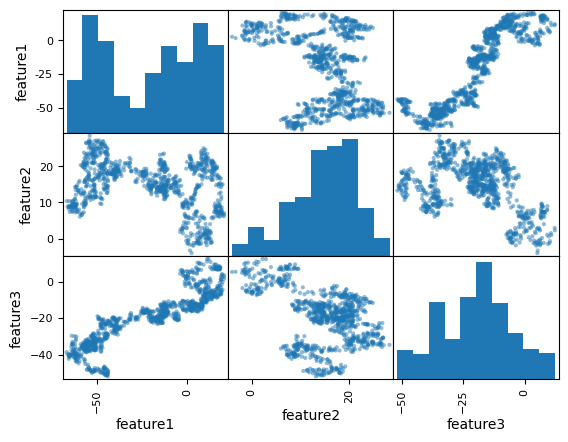

In [3]:
pd.plotting.scatter_matrix(time_series_data)
plt.show()

### 相関行列

In [4]:
time_series_data.drop('time', axis=1).corr().style.background_gradient(axis=None, cmap="jet")

,feature1,feature2,feature3
feature1,1.000000,-0.330607,0.889248
feature2,-0.330607,1.000000,-0.414987
feature3,0.889248,-0.414987,1.000000


## Batch process
- サンプルサイズ全て用いて PCA を行う

In [5]:
n_components = 2
batch_pca = PCA(n_components=n_components)
principal_components = batch_pca.fit_transform(X)

# 結果をデータフレームに変換
principal_df = pd.DataFrame(data=principal_components, columns=[f'principal_component_{i + 1}' for i in range(n_components)])

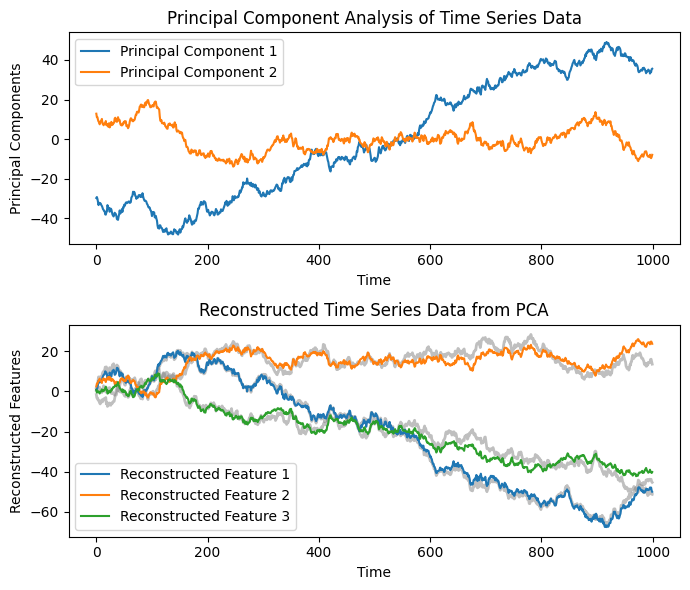

In [6]:
# 再構成されたデータを取得
X_reconstructed = batch_pca.inverse_transform(principal_components)

# 再構成されたデータをデータフレームに変換
reconstructed_df = pd.DataFrame(data=X_reconstructed, columns=['reconstructed_feature1', 'reconstructed_feature2', 'reconstructed_feature3'])

# 時間軸を追加
reconstructed_df['time'] = time_series_data['time']

# 主成分のプロット
plt.figure(figsize=(7, 6))

plt.subplot(2, 1, 1)
plt.plot(principal_df['principal_component_1'], label='Principal Component 1')
plt.plot(principal_df['principal_component_2'], label='Principal Component 2')
plt.xlabel('Time')
plt.ylabel('Principal Components')
plt.title('Principal Component Analysis of Time Series Data')
plt.legend()

# 再構成されたデータのプロット
plt.subplot(2, 1, 2)
plt.plot(X, c='gray', alpha=0.5, linewidth=2)
plt.plot(reconstructed_df['reconstructed_feature1'], label='Reconstructed Feature 1')
plt.plot(reconstructed_df['reconstructed_feature2'], label='Reconstructed Feature 2')
plt.plot(reconstructed_df['reconstructed_feature3'], label='Reconstructed Feature 3')
plt.xlabel('Time')
plt.ylabel('Reconstructed Features')
plt.title('Reconstructed Time Series Data from PCA')
plt.legend()

plt.tight_layout()
plt.show()

## Stream process (SPIRIT, Papadimitriou et al., VLDB2005)
- 最初の batch_size (<< サンプルサイズ) 分だけのデータを用いて PCA を行う
- その後、新たなデータに対して、固定行列サイズである W の更新を行う
- [Streaming pattern discovery in multiple time-series](https://kilthub.cmu.edu/articles/journal_contribution/Streaming_Pattern_Discovery_in_Multiple_Time-Series/6609941)

In [7]:
class SPIRIT:
    def __init__(self, forgetting_factor=0.96, verbose=True):
        self.forgetting_factor = forgetting_factor
        self.verbose = verbose

    def batch(self, X, n_components=None, threshold=0.9):
        pca = PCA()
        _Z = pca.fit_transform(X)
        self.n = X.shape[0]
        if n_components is not None:
            self.k = n_components
        else:
            self.k = np.argmax(pca.explained_variance_ratio_.cumsum() > threshold) + 1
        self.Z = _Z[:, :self.k].T
        self.W = pca.components_[:self.k]
        self.mean = pca.mean_
        _forgettings = np.power(self.forgetting_factor, np.arange(self.n - 1, -1, -1))
        self.energy = np.sum(np.square(self.W @ X.T) * _forgettings, axis=1)

        if self.verbose:
            print(f"size: {X.shape[0]}")
            print(f"Z (principal components): {self.Z.shape}")
            print(f"W (principal directions): {self.W.shape}")

        self.reconstruction = self.Z.T @ self.W + self.mean

    def update(self, new_data):
        new_data_centered = (new_data - self.mean)

        new_Z = np.zeros((self.k, 1))
        for i in range(self.k):
            new_z = self.W[i] @ new_data_centered
            self.energy[i] = self.forgetting_factor * self.energy[i] + np.square(new_z)
            err = new_data_centered - new_z * self.W[i]
            self.W[i] += new_z * err / self.energy[i]
            new_data_centered -= new_z * self.W[i]
            new_Z[i] = new_z
        self.Z = np.concatenate([self.Z, new_Z], axis=1)
        self.reconstruction = np.concatenate([self.reconstruction, (new_Z.T @ self.W + self.mean)], axis=0)

        self.mean = (self.n * self.mean + new_data) / (self.n + 1)
        self.n += 1

In [8]:
batch_size = 50

spirit = SPIRIT(forgetting_factor=0.97)
spirit.batch(X=X[:batch_size], n_components=2)
spirit_time = list()

for t in range(batch_size, X.shape[0]):
    tic = time.time()
    spirit.update(X[t])
    spirit_time.append(time.time() - tic)

size: 50
Z (principal components): (2, 50)
W (principal directions): (2, 3)


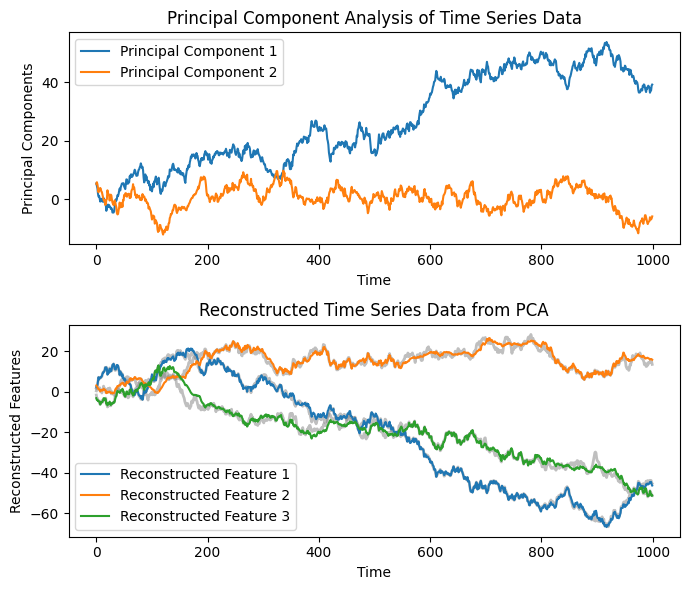

In [9]:
# 主成分のプロット
plt.figure(figsize=(7, 6))

plt.subplot(2, 1, 1)
plt.plot(spirit.Z[0], label='Principal Component 1')
plt.plot(spirit.Z[1], label='Principal Component 2')
plt.xlabel('Time')
plt.ylabel('Principal Components')
plt.title('Principal Component Analysis of Time Series Data')
plt.legend()

# 再構成されたデータのプロット
plt.subplot(2, 1, 2)
plt.plot(X, c='gray', alpha=0.5, linewidth=2)
plt.plot(spirit.reconstruction[:, 0], label='Reconstructed Feature 1')
plt.plot(spirit.reconstruction[:, 1], label='Reconstructed Feature 2')
plt.plot(spirit.reconstruction[:, 2], label='Reconstructed Feature 3')
plt.xlabel('Time')
plt.ylabel('Reconstructed Features')
plt.title('Reconstructed Time Series Data from PCA')
plt.legend()

plt.tight_layout()
plt.show()

## Summary

In [10]:
print("===== Batch PCA =====")
print(f"matrix W:\n{batch_pca.components_}")
print(f"mean:\n{batch_pca.mean_}")
print()
print("===== Track PCA =====")
print(f"matrix W:\n{spirit.W}")
print(f"mean:\n{spirit.mean}")

===== Batch PCA =====
matrix W:
[[-0.88889907  0.08246306 -0.45061989]
 [-0.34780988 -0.76166673  0.54671023]]
mean:
[-21.09762647  14.79140045 -19.76275818]

===== Track PCA =====
matrix W:
[[-0.72908407 -0.00813441 -0.68476232]
 [-0.57259686 -0.2409593   0.78478482]]
mean:
[-21.09762647  14.79140045 -19.76275818]


### Principal Components

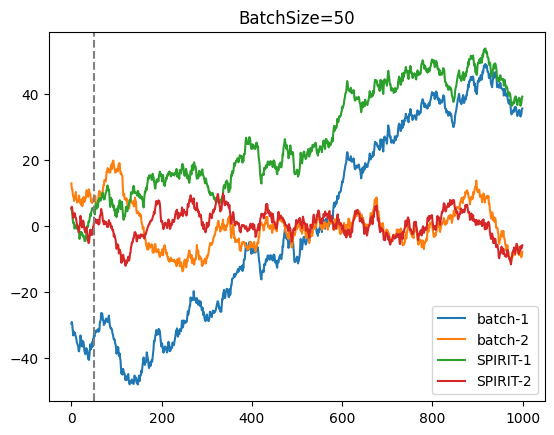

In [11]:
plt.plot(principal_components[:, 0], label="batch-1")
plt.plot(principal_components[:, 1], label="batch-2")
plt.plot(spirit.Z[0], label="SPIRIT-1")
plt.plot(spirit.Z[1], label="SPIRIT-2")

plt.axvline(x=batch_size, color='gray', linestyle='--')

plt.title(f"BatchSize={batch_size}")
plt.legend()

### Scalability

In [12]:
# サンプルの時系列データを生成
np.random.seed(0)
size = 10000
time_series_data = pd.DataFrame({
    'time': pd.date_range(start='1/1/2020', periods=size, freq='D'),
    'feature1': np.random.randn(size).cumsum(),
    'feature2': np.random.randn(size).cumsum(),
    'feature3': np.random.randn(size).cumsum()
})

X = time_series_data[['feature1', 'feature2', 'feature3']].values
print(f"X: {X.shape}")

X: (10000, 3)


In [13]:
n_components = 2
batch_pca = PCA(n_components=n_components)
batch_time = [0] * X.shape[0]
for t in range(batch_size, X.shape[0]):
    tic = time.time()
    principal_components = batch_pca.fit_transform(X[:t])
    batch_time[t] += time.time() - tic

In [14]:
batch_size = 50
spirit_time = [0] * X.shape[0]
for _ in range(30):
    spirit = SPIRIT(forgetting_factor=0.97, verbose=False)
    spirit.batch(X=X[:batch_size], n_components=2)

    for t in range(batch_size, X.shape[0]):
        tic = time.time()
        spirit.update(X[t])
        spirit_time[t] += time.time() - tic
spirit_time = np.array(spirit_time) / 30

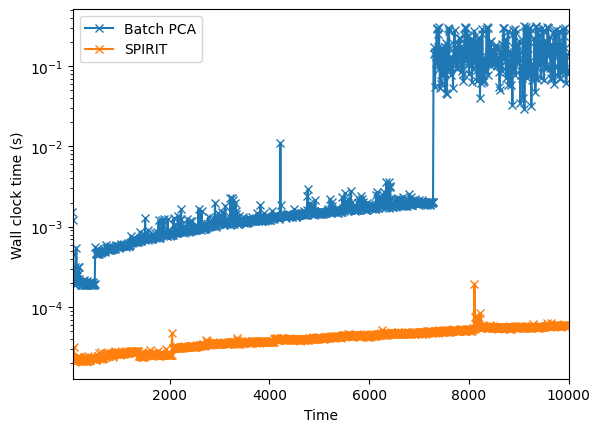

In [15]:
plt.plot(np.arange(0, size, 10), batch_time[::10], label="Batch PCA", marker='x')
plt.plot(np.arange(0, size, 10), spirit_time[::10], label="SPIRIT", marker='x')

plt.xlabel('Time')
plt.ylabel('Wall clock time (s)')

plt.yscale('log')
plt.xlim(batch_size + 10, X.shape[0])

plt.legend()